# Adversarial Attack

In [1]:
from auxiliar_code import *

Using TensorFlow backend.


### Load and show Images

In [2]:
original_image = load_image("water_bottle.jpg")
hacked_image = load_image("hacked_water.png")

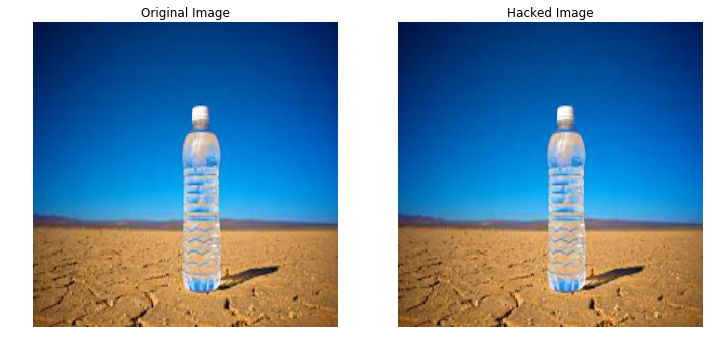

In [3]:
plot_images_contrast(original_image, hacked_image)

### Load Inception Neural Network

In [4]:
nn = load_neural_network("inception")

### Predict

In [5]:
predict(nn, original_image)

water_bottle


In [6]:
predict(nn, hacked_image)

beer_glass


### Explanation

In [7]:
target_class = 441 # Beer Glass Class
# Classes: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
im = preprocess_image(original_image)

inp_layer = nn.layers[0].input # Image
out_layer = nn.layers[-1].output # Probabilities

loss = out_layer[0, target_class]
grad = K.gradients(loss, inp_layer)[0]
optimize_gradient = K.function([inp_layer, K.learning_phase()], [grad, loss])
adv = np.copy(im)

In [11]:
certainty = 0.0

max_pert = im + 0.01
min_pert = im - 0.01

while certainty < 0.95:
    gr, certainty = optimize_gradient([adv, 0])
    adv += gr
    adv = np.clip(adv, min_pert, max_pert)
    adv = np.clip(adv, -1 , 1)
    print("Certainty Degree", certainty)

Certainty Degree 9.625923e-05
Certainty Degree 9.788217e-05
Certainty Degree 9.9523866e-05
Certainty Degree 0.000101184436
Certainty Degree 0.0001029005
Certainty Degree 0.00010468727
Certainty Degree 0.00010653436
Certainty Degree 0.00010842392
Certainty Degree 0.00011031588
Certainty Degree 0.00011219338
Certainty Degree 0.00011408975
Certainty Degree 0.00011601707
Certainty Degree 0.00011797373
Certainty Degree 0.000119983466
Certainty Degree 0.0001220342
Certainty Degree 0.00012410362
Certainty Degree 0.00012624299
Certainty Degree 0.00012841694
Certainty Degree 0.00013059977
Certainty Degree 0.00013279554
Certainty Degree 0.00013500333
Certainty Degree 0.00013725355
Certainty Degree 0.00013958788
Certainty Degree 0.0001419894
Certainty Degree 0.00014441588
Certainty Degree 0.00014682669
Certainty Degree 0.00014925866
Certainty Degree 0.00015171699
Certainty Degree 0.00015420222
Certainty Degree 0.00015674514
Certainty Degree 0.00015932693
Certainty Degree 0.0001619607
Certainty De

### Trick Summary

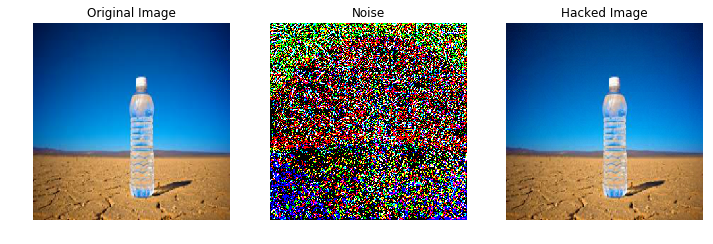

In [12]:
im = denormalise(im.reshape(im.shape[1], im.shape[2], im.shape[3]))
adv = denormalise(adv.reshape(adv.shape[1], adv.shape[2], adv.shape[3]))
plot_images_noise(im, adv)

## Save the Adv Image

In [13]:
# It would be recommended to point the NN hacked
matplotlib.image.imsave('hacked_water_inception.png', adv)

## Try again

In [20]:
decode_predictions(nn.predict(preprocess_input(adv.reshape(1, adv.shape[0], adv.shape[1], adv.shape[2]))))

[[('n02823750', 'beer_glass', 0.9990682),
  ('n02815834', 'beaker', 0.00014170076),
  ('n03443371', 'goblet', 0.00013050849),
  ('n02948072', 'candle', 7.876703e-05),
  ('n03916031', 'perfume', 6.147348e-05)]]